# Age determination 🔎

Сетевой супермаркет «Хлеб-Соль» внедряет систему компьютерного зрения для обработки фотографий покупателей. Фотофиксация в прикассовой зоне поможет определять возраст клиентов, чтобы:

- анализировать покупки и предлагать товары, которые могут заинтересовать покупателей этой возрастной группы;
- контролировать добросовестность кассиров при продаже алкоголя.

Необходимо построить модель, которая по фотографии определит приблизительный возраст человека. В нашем распоряжении набор фотографий людей с указанием возраста.

Перед нами задача регрессии. На выходе будет 1 слой с ReLU функцией активации, чтобы, например привести к 0 все отрицательные числа.

Данные взяты с сайта [ChaLearn Looking at People](http://chalearnlap.cvc.uab.es/dataset/26/description/).

**Содержание**<a id='toc0_'></a>    
1. [Подготовка  ](#toc1_)    
1.1. [Библиотеки  ](#toc1_1_)    
1.2. [Конфигурация  ](#toc1_2_)    
2. [Данные  ](#toc2_)    
2.1. [Загрузка  ](#toc2_1_)    
2.2. [Распределение по возрастам  ](#toc2_2_)    
2.3. [Визуальный осмотр  ](#toc2_3_)    
2.4. [Выводы по данным  ](#toc2_4_)    
3. [Предсказание  ](#toc3_)    
3.1. [Загрузчики  ](#toc3_1_)    
3.2. [Модель  ](#toc3_2_)    
4. [Результаты ](#toc4_)    
4.1. [Проверка на тесте ](#toc4_1_)    
5. [Итоговый вывод  ](#toc5_)    

<!-- vscode-jupyter-toc-config
	numbering=true
	anchor=true
	flat=true
	minLevel=2
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

## 1. <a id='toc1_'></a>Подготовка   [&#8593;](#toc0_)

### 1.1. <a id='toc1_1_'></a>Библиотеки   [&#8593;](#toc0_)

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from termcolor import colored
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (Dense,
                                     GlobalAveragePooling2D)
from tensorflow.keras.optimizers import Adam

### 1.2. <a id='toc1_2_'></a>Конфигурация   [&#8593;](#toc0_)

In [2]:
IMAGE_SIZE = (224, 224)
RANDOM_STATE = 27
BATCH_SIZE = 32
EPOCHS = 10

## 2. <a id='toc2_'></a>Данные   [&#8593;](#toc0_)

### 2.1. <a id='toc2_1_'></a>Загрузка   [&#8593;](#toc0_)

In [3]:
y_train = pd.read_csv('./data/gt_train.csv', usecols=['file_name', 'real_age']).drop_duplicates()
y_train.head()

,file_name,real_age
0,000000.jpg,4
36,000001.jpg,18
99,000002.jpg,80
137,000003.jpg,50
175,000004.jpg,17


In [4]:
y_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4113 entries, 0 to 133867
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  4113 non-null   object
 1   real_age   4113 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 96.4+ KB


In [5]:
y_train.describe()

,real_age
count,4113.000000
mean,30.476052
std,16.312428
min,1.000000
25%,19.000000
50%,28.000000
75%,40.000000
max,100.000000


### 2.2. <a id='toc2_2_'></a>Распределение по возрастам   [&#8593;](#toc0_)

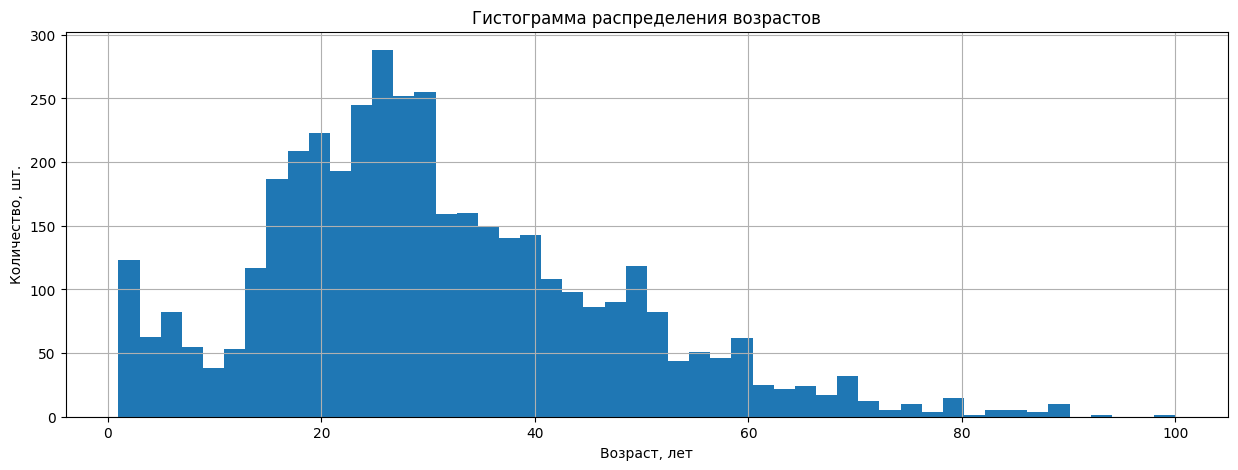

In [6]:
plt.figure(figsize=(15, 5))
y_train['real_age'].hist(bins=50)
plt.title('Гистограмма распределения возрастов')
plt.xlabel('Возраст, лет')
plt.ylabel('Количество, шт.')
plt.show()

### 2.3. <a id='toc2_3_'></a>Визуальный осмотр   [&#8593;](#toc0_)

In [7]:
train_datagen = ImageDataGenerator(rescale=1./255)
train_gen_flow = train_datagen.flow_from_dataframe(
        dataframe=y_train,
        directory='./data/train',
        x_col='file_name',
        y_col='real_age',
        target_size=IMAGE_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='raw',
        seed=RANDOM_STATE)

Found 4113 validated image filenames.


In [8]:
images, labels = next(train_gen_flow)
images = images[:10]
labels = labels[:10]

In [9]:
rows, cols = 5, 2

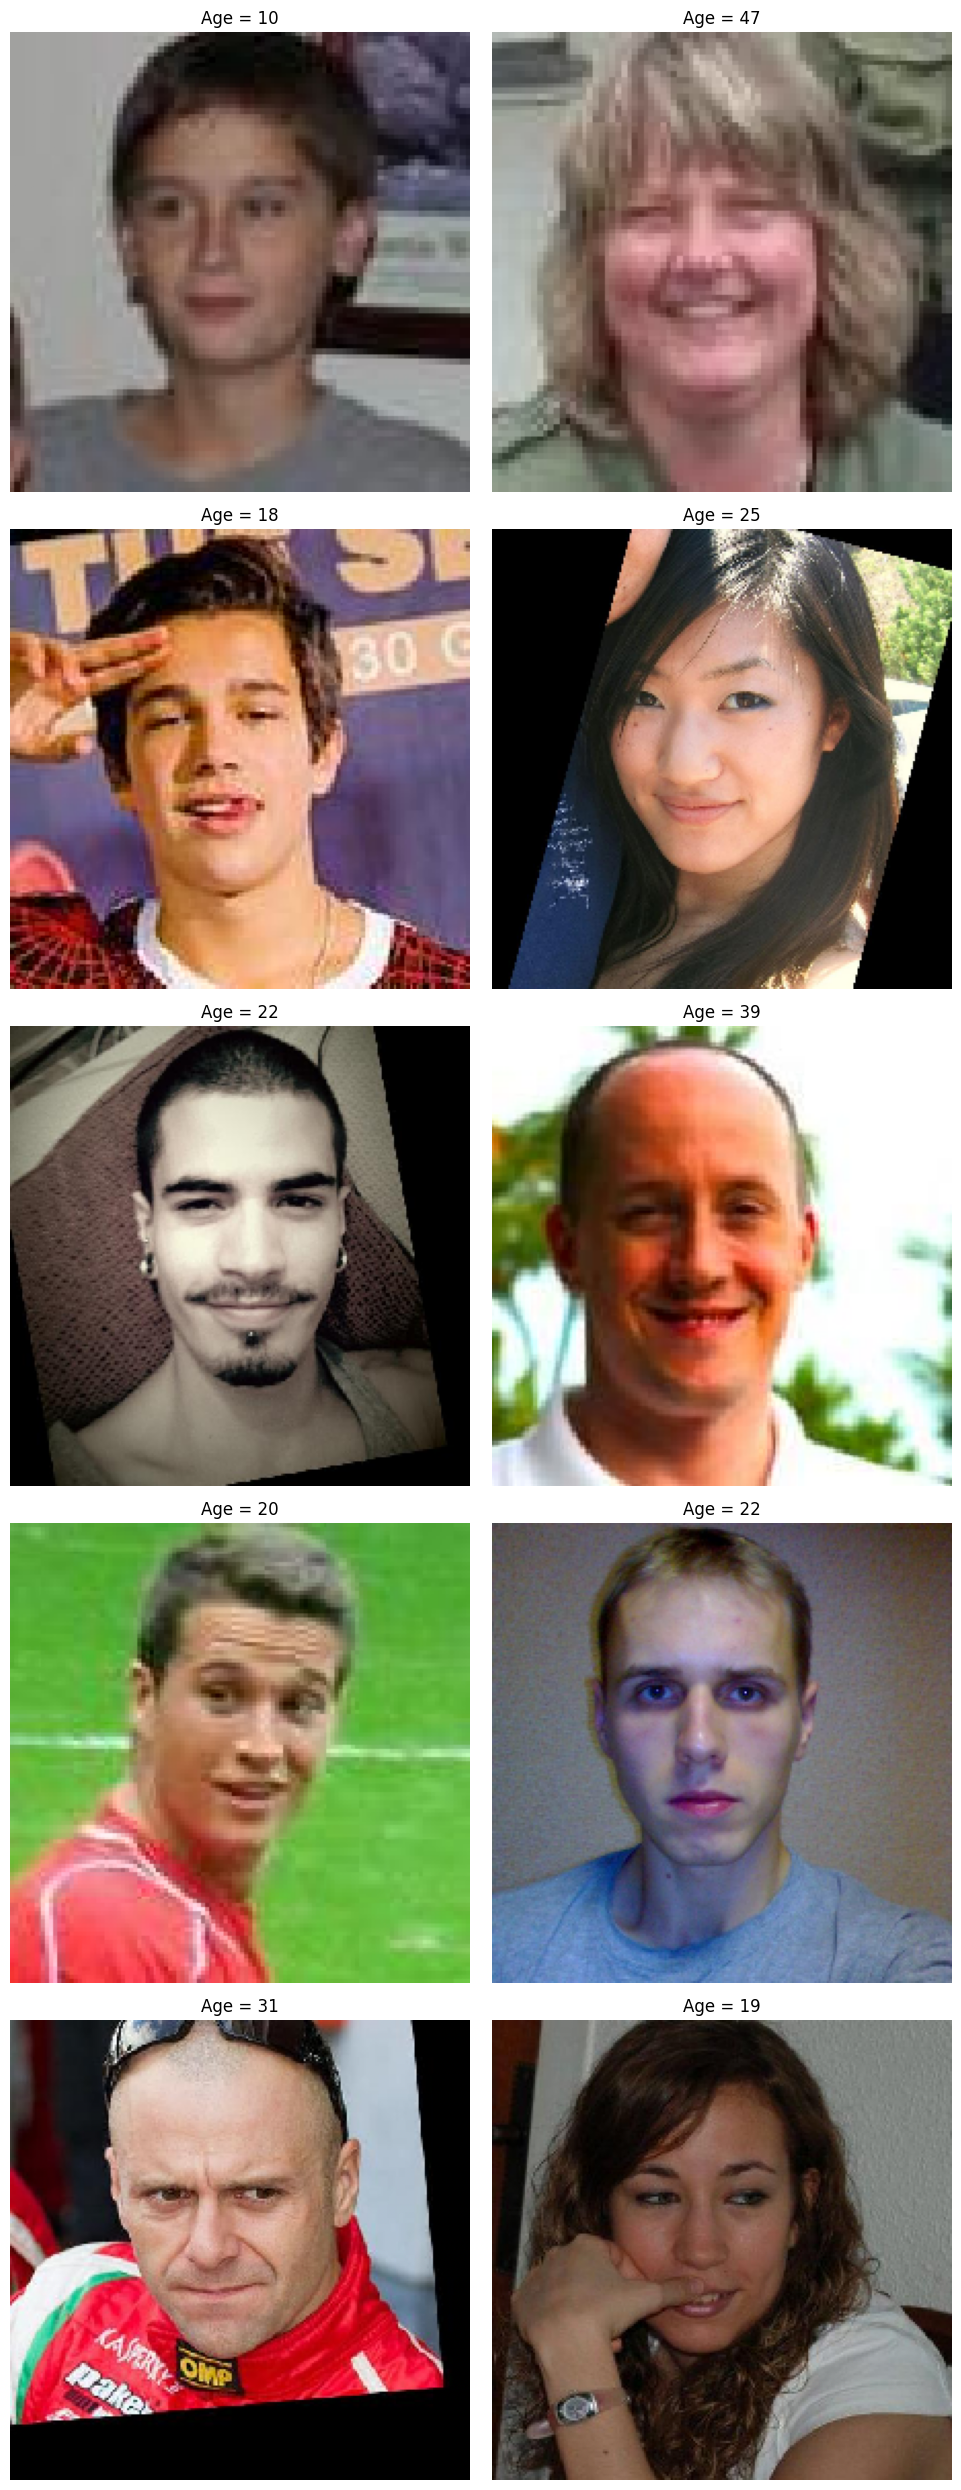

In [10]:
fig, axes = plt.subplots(rows, cols, figsize=(10, 5 * rows))

for i, (img, label) in enumerate(zip(images, labels)):
    row = i // cols
    col = i % cols
    ax = axes[row, col]
    ax.imshow(img)
    ax.set_title(f'Age = {label}')
    ax.axis('off')

plt.tight_layout()
plt.show()

### 2.4. <a id='toc2_4_'></a>Выводы по данным   [&#8593;](#toc0_)

Представлены изображения людей обоих полов и самых разных возрастов. Присутствуют изображения, которые повернуты и/или обрезаны. Распределение возрастов смещено влево (в сторону меньшего возраста). Также заметны пики на юбилейных годах (20, 25, 30...). Возможно, это связано с округлением при сборе информации.

## 3. <a id='toc3_'></a>Предсказание   [&#8593;](#toc0_)

### 3.1. <a id='toc3_1_'></a>Загрузчики   [&#8593;](#toc0_)

In [11]:
y_train = pd.read_csv('./data/gt_train.csv', usecols=['file_name', 'real_age']).drop_duplicates()

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    width_shift_range=0.2,
    height_shift_range=0.2,
    rotation_range=20)

train_datagen_flow = train_datagen.flow_from_dataframe(
    dataframe=y_train,
    directory='./data/train',
    x_col='file_name',
    y_col='real_age',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 4113 validated image filenames.


In [12]:
y_valid = pd.read_csv('./data/gt_valid.csv', usecols=['file_name', 'real_age']).drop_duplicates()

valid_datagen = ImageDataGenerator(rescale=1./255)

valid_datagen_flow = valid_datagen.flow_from_dataframe(
    dataframe=y_valid,
    directory='./data/valid',
    x_col='file_name',
    y_col='real_age',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 1500 validated image filenames.


In [13]:
y_test = pd.read_csv('./data/gt_test.csv', usecols=['file_name', 'real_age']).drop_duplicates()

test_datagen = ImageDataGenerator(rescale=1./255)

test_datagen_flow = test_datagen.flow_from_dataframe(
    dataframe=y_test,
    directory='./data/test',
    x_col='file_name',
    y_col='real_age',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='raw',
    seed=RANDOM_STATE)

Found 1978 validated image filenames.


### 3.2. <a id='toc3_2_'></a>Модель   [&#8593;](#toc0_)

In [14]:
backbone = ResNet50(weights='imagenet',
                    include_top=False,
                    input_shape=(224, 224, 3))

model = Sequential([
    backbone,
    GlobalAveragePooling2D(),
    Dense(256, activation='relu'),
    Dense(1, activation='relu')
])

optimizer = Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
                loss='mse',
                metrics=['mae'])

In [15]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    print(colored('Обнаружено GPU:', 'green'), gpus)
else:
    print(colored('GPU не обнаружено. Будет использован CPU.', 'red'))

GPU не обнаружено. Будет использован CPU.


In [16]:
history = model.fit(
    train_datagen_flow,
    steps_per_epoch=len(train_datagen_flow),
    validation_data=valid_datagen_flow,
    validation_steps=len(valid_datagen_flow),
    epochs=EPOCHS,
    verbose=1
)

c:\Users\dolbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 363s 3s/step - loss: 440.3372 - mae: 15.5872 - val_loss: 602.2544 - val_mae: 19.7274
Epoch 2/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 331s 3s/step - loss: 90.8532 - mae: 7.3424 - val_loss: 531.3976 - val_mae: 18.1308
Epoch 3/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 70.9647 - mae: 6.4841 - val_loss: 415.8360 - val_mae: 15.3954
Epoch 4/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 325s 3s/step - loss: 57.4735 - mae: 5.8047 - val_loss: 296.6235 - val_mae: 12.7773
Epoch 5/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 345s 3s/step - loss: 51.3875 - mae: 5.5695 - val_loss: 181.3082 - val_mae: 9.9006
Epoch 6/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 278s 2s/step - loss: 44.5807 - mae: 5.1088 - val_loss: 121.3029 - val_mae: 8.0047
Epoch 7/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - loss: 34.7026 - mae: 4.5630 - val_loss: 94.3183 - val_mae: 7.1229
Epoch 8/10
129/129 ━━━━━━━━━━━━━━━━━━━━ 270s 2s/step - loss: 35.9040 - mae: 4.6167 - val_loss: 102.7505 - val_mae: 7.4482
Epoch 9/10
129/129 

In [ ]:
model.save('age_model.h5')

## 4. <a id='toc4_'></a>Результаты  [&#8593;](#toc0_)

### 4.1. <a id='toc4_1_'></a>Проверка на тесте  [&#8593;](#toc0_)

In [17]:
test_loss, test_mae = model.evaluate(test_datagen_flow, steps=len(test_datagen_flow))
print(f"test loss: {test_loss}, test MAE: {test_mae}")

c:\Users\dolbi\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


62/62 ━━━━━━━━━━━━━━━━━━━━ 30s 483ms/step - loss: 119.1427 - mae: 7.8127
test loss: 132.32406616210938, test MAE: 8.114460945129395


## 5. <a id='toc5_'></a>Итоговый вывод   [&#8593;](#toc0_)

В рамках данного проекта мы работали с датасетом, содержащим изображения людей. Целевой признак - их возраст. В датасете представлены изображения людей обоих полов и самых разных возрастов.

В качестве модели использовался бэкбон *ResNet50* с весами от *imagenet*, один скрытый Dense слой с `256` нейронами и 1 выходной слой с ожидаемо `1` нейроном. Использовалась ReLU функция активации в обоих слоях. В результате, получена метрика `MSE ~ 8`, что лучше, чем требовалось.

Однако использовать такую модель в реальной жизни не стоит. Ошибка в `8` лет довольна критична для целей заказчика. Ведь у людей 8 и 16 лет совершенно разные "интересные им" товары. Модель могла бы быть относительно полезной для людей старшей возрастной категории - люди в 50 и 58 покупают примерно одно.